# Key Changes

Check for GPU availability
```
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
```

Move tensors to GPU (in `MIMICDataProcessor`)
```
self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32).to(device)
self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32).to(device)
self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32).to(device)
self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32).to(device)
```

Move model and data to GPU during training and testing (in `train()`)
```
x_to_c = MultiOutputNN(num_features=x_size, num_outputs=c_size).to(device)
c_to_y = MultiOutputNN(num_features=c_size, num_outputs=y_size).to(device)
```

Ensure tensors are on the same device (in `train()` within the Testing Loop)
```
x, c, y = x.to(device), c.to(device), y.to(device)
```

Detach tensors and move them to CPU for evaluation and plotting (in `train()` within the Training and Testing Loop)
```
x_to_c_predictions.append(predicted_c.detach().cpu().numpy())
c_to_y_predictions.append(predicted_y.detach().cpu().numpy())
x_to_c_test_predictions.append(predicted_c.detach().cpu().numpy())
c_to_y_test_predictions.append(predicted_y.detach().cpu().numpy())
ground_truth_test_c.append(c.cpu())
ground_truth_test_y.append(y.cpu())
```



# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Initialise GPU

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading and Pre-processing

In [3]:
# Class for pre-processing the data
class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.scaler = StandardScaler()

        # Load and preprocess the data
        self.df = pd.read_csv(file_path)
        # Replace all missing values with 0
        self.df.fillna(0, inplace=True)

        # Features
        self.X = self.df[['upper_respiratory_infections', 'influenza_pneumonia', 'acute_lower_respiratory_infections', 'chronic_lower_respiratory_diseases',
                          'lung_diseases_due_to_external_agents', 'other_respiratory_diseases', 'InvasiveVent', 'SupplementalOxygen', 'HFNC',
                          'NonInvasiveVent', 'Tracheostomy', 'None', 'avg_uo_24hr', 'avg_creatinine_max', 'max_renal_uo_24hr', 'max_renal_creatinine_max',
                          'avg_pao2fio2ratio_novent', 'avg_pao2fio2ratio_vent', 'max_respiration_pao2fio2ratio_novent', 'max_respiration_pao2fio2ratio_vent', 'avg_gcs_min', 'max_cns_gcs_min',
                          'sofa_score', 'suspected_infection', 'one_vasopressor', 'multi_vasopressor']]

        # Concepts
        self.C = self.df[['c_rsp_mod', 'c_rsp_svr', 'c_vent_low', 'c_vent_moderate', 'c_vent_high', 'c_max_renf_moderate', 'c_max_renf_severe',
                          'c_avg_renf_moderate', 'c_avg_renf_severe', 'c_max_respf_moderate', 'c_max_respf_severe', 'c_avg_respf_moderate',
                          'c_avg_respf_severe', 'c_max_cnsf_moderate', 'c_max_cnsf_severe', 'c_avg_cnsf_moderate', 'c_avg_cnsf_severe',
                          'c_sepsis3', 'c_shock']]

        # Label
        self.Y = self.df['ARDS']


        # Convert to tensors
        self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32)
        self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32)
        self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32)

        # Normalize the features
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32)

    def get_features(self):
        return self.X.columns.tolist()

    def get_concepts(self):
        return self.C.columns.tolist()

    def get_labels(self):
        return self.Y.columns.tolist()

    # Dataset class needed to provide the __getitem__ method for DataLoader
    class MIMICDataset(Dataset):
        def __init__(self, x, c, y):
            self.x = x
            self.c = c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.y[idx]

    def create_dataloaders(self):
        # Split the data into temporary (80%) and test (20%) sets
        X_temp, X_test, C_temp, C_test, Y_temp, Y_test = train_test_split(
            self.X_tensor_scaled, self.C_tensor, self.Y_tensor, test_size=0.20, random_state=42)

        # Further split the temporary data into training (75% of temporary) and validation (25% of temporary) sets
        X_train, X_val, C_train, C_val, Y_train, Y_val = train_test_split(
            X_temp, C_temp, Y_temp, test_size=0.25, random_state=42)

        train_dataset = self.MIMICDataset(X_train, C_train, Y_train)
        val_dataset = self.MIMICDataset(X_val, C_val, Y_val)
        test_dataset = self.MIMICDataset(X_test, C_test, Y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# Model

In [4]:
class MultiOutputNN(nn.Module):
    def __init__(self, num_features, num_outputs):
        super(MultiOutputNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, num_outputs)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output_layer(x)  # No activation function
        return x

# Training

Look at the Step 5 from this [basic code](https://colab.research.google.com/drive/1LqE89tPVt6h1wa7lerLgF4GNvRw9QFDw?usp=sharing) for reference.

In [5]:
def train(x_size, c_size, y_size, x_to_c_learning_rate, c_to_y_learning_rate, epochs, train_loader, val_loader):
    torch.manual_seed(25)

    x_to_c = MultiOutputNN(num_features=x_size, num_outputs=c_size).to(device)  # concept predictor
    c_to_y = MultiOutputNN(num_features=c_size, num_outputs=y_size).to(device)  # label predictor

    criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
    x_to_c_optimizer = torch.optim.Adam(x_to_c.parameters(), lr=x_to_c_learning_rate)
    c_to_y_optimizer = torch.optim.Adam(c_to_y.parameters(), lr=c_to_y_learning_rate)

    epochs_count = []
    x_to_c_loss_values, c_to_y_loss_values = [], []
    x_to_c_predictions, c_to_y_predictions = [], []
    x_to_c_val_loss_values, c_to_y_val_loss_values = [], []
    x_to_c_val_predictions, c_to_y_val_predictions = [], []
    ground_truth_val_c, ground_truth_val_y = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        x_to_c.train()
        c_to_y.train()

        running_x_to_c_loss, running_c_to_y_loss = 0.0, 0.0
        total_samples = 0

        for i, batch in enumerate(train_loader):
            x, c, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Forward pass through x_to_c
            x_to_c_optimizer.zero_grad()
            x = x.to(x_to_c.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c = x_to_c(x)
            x_to_c_predictions.append(predicted_c.detach().cpu().numpy())
            c_loss = criterion(predicted_c, c.float())

            # Backward pass through x_to_c
            c_loss.backward()
            x_to_c_optimizer.step()

            # Forward pass through c_to_y
            c_to_y_optimizer.zero_grad()
            predicted_y = c_to_y(c)
            c_to_y_predictions.append(predicted_y.detach().cpu().numpy())
            y_loss = criterion(predicted_y, y.unsqueeze(1).float())

            # Backward pass through c_to_y
            y_loss.backward()
            c_to_y_optimizer.step()

            # Accumulate loss values
            running_x_to_c_loss += c_loss.item()
            running_c_to_y_loss += y_loss.item()

            total_samples += len(y)

        x_to_c_loss_values.append(running_x_to_c_loss / len(train_loader))
        c_to_y_loss_values.append(running_c_to_y_loss / len(train_loader))

        # valing Loop
        x_to_c.eval()
        c_to_y.eval()

        running_x_to_c_val_loss, running_c_to_y_val_loss = 0.0, 0.0
        total_val_samples = 0

        with torch.no_grad():
            for x, c, y in val_loader:
                x, c, y = x.to(device), c.to(device), y.to(device)

                ground_truth_val_c.append(c.cpu())
                ground_truth_val_y.append(y.cpu())

                # Forward pass through x_to_c
                predicted_c = x_to_c(x.to(dtype=x_to_c.layer1.weight.dtype))
                x_to_c_val_predictions.append(predicted_c.detach().cpu().numpy())
                c_loss = criterion(predicted_c, c.float())

                # Accumulate x_to_c loss for valing
                running_x_to_c_val_loss += c_loss.item()

                # Forward pass through c_to_y
                predicted_y = c_to_y(c)
                c_to_y_val_predictions.append(predicted_y.detach().cpu().numpy())
                y_loss = criterion(predicted_y, y.unsqueeze(1).float())

                # Accumulate c_to_y loss for valing
                running_c_to_y_val_loss += y_loss.item()
                total_val_samples += len(y)

        x_to_c_val_loss_values.append(running_x_to_c_val_loss / len(val_loader))
        c_to_y_val_loss_values.append(running_c_to_y_val_loss / len(val_loader))

    return (x_to_c, c_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y)

In [6]:
# Specify Parameters
x_size = 26
c_size = 19
y_size = 1
x_to_c_learning_rate = 0.01
c_to_y_learning_rate = 0.01
epochs = 60

# Load Data
file_path = '/content/ards6-total.csv'
data_processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, test_loader, val_loader = data_processor.create_dataloaders()

x_to_c, c_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y = train(x_size, c_size, y_size, x_to_c_learning_rate, c_to_y_learning_rate, epochs, train_loader, val_loader)

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


# Plotting Loss

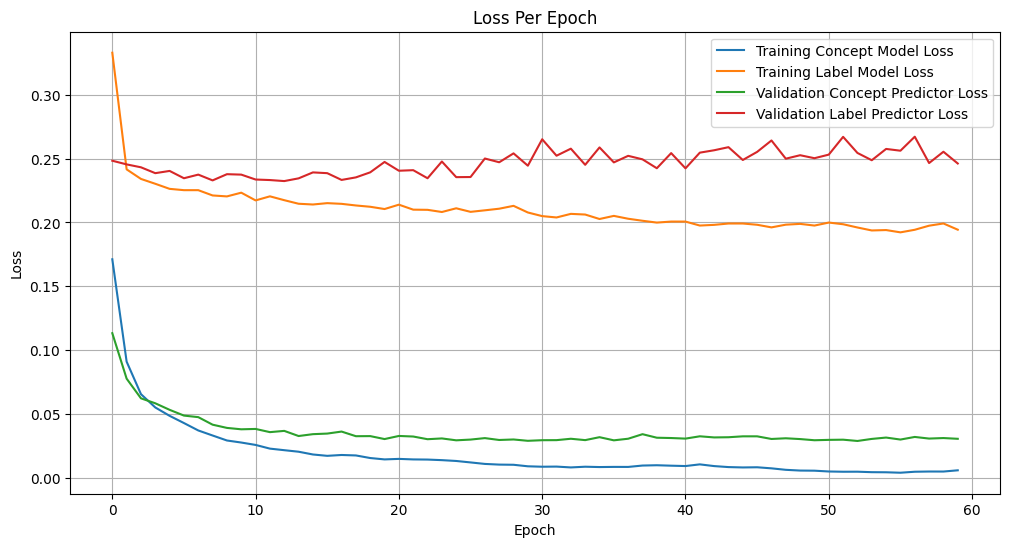

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Training Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Training Label Model Loss')
plt.plot(epochs_count, x_to_c_val_loss_values, label='Validation Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Validation Label Predictor Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

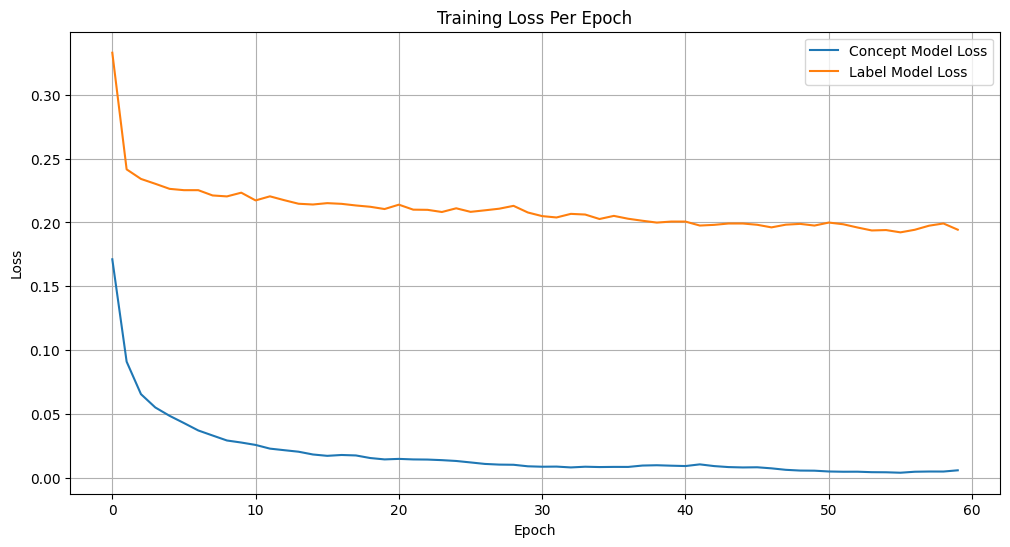

In [8]:
# Training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Label Model Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

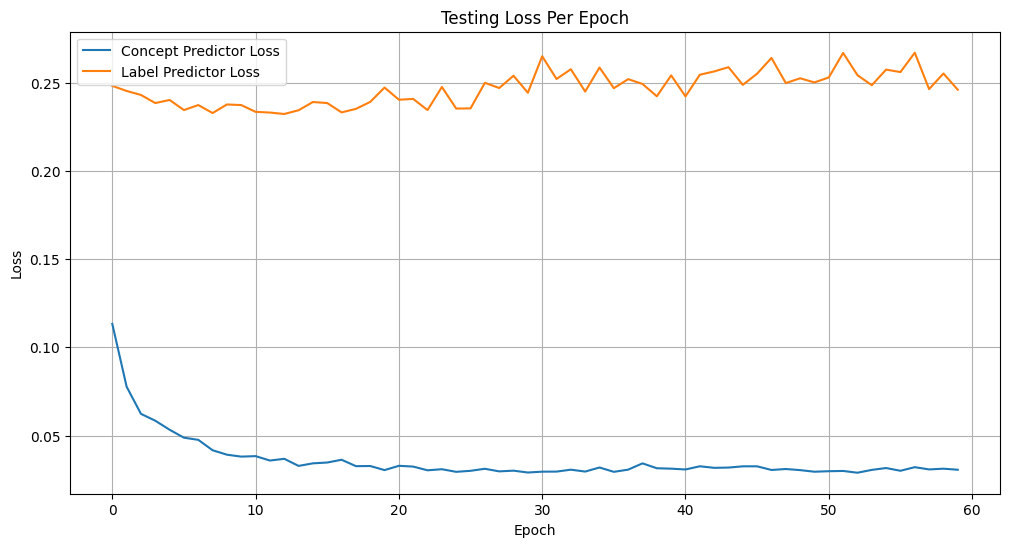

In [9]:
# Testing loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_val_loss_values, label='Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Label Predictor Loss')
plt.title('Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Validation Evaluation

In [10]:
# Concept Predictor Evaluation
def evaluate_concept_predictor(ground_truth_c, x_to_c_predictions, concept_labels):
    results = []
    for i, label in enumerate(concept_labels):
        true_values = np.concatenate([c[:, i].numpy() for c in ground_truth_c])
        predicted_values = np.concatenate([c[:, i] for c in x_to_c_predictions])

        mse = mean_squared_error(true_values, predicted_values)
        mae = mean_absolute_error(true_values, predicted_values)
        r2 = r2_score(true_values, predicted_values)

        results.append({
            "Label": label,
            "MSE": mse,
            "MAE": mae,
            "R2": r2
        })
    return pd.DataFrame(results)

In [11]:
# Get concept labels from the data processor
concept_labels = data_processor.get_concepts()

# Evaluation
concept_predictor_results = evaluate_concept_predictor(ground_truth_val_c, x_to_c_val_predictions, concept_labels)
print("Validation Concept Predictor Results:")
print(concept_predictor_results)

Validation Concept Predictor Results:
                   Label       MSE       MAE        R2
0              c_rsp_mod  0.017416  0.074950  0.907570
1              c_rsp_svr  0.010855  0.058882  0.932775
2             c_vent_low  0.010922  0.068132  0.943817
3        c_vent_moderate  0.007681  0.050137  0.933530
4            c_vent_high  0.005240  0.048792 -0.066330
5    c_max_renf_moderate  0.065367  0.170513  0.703619
6      c_max_renf_severe  0.061762  0.151099  0.751091
7    c_avg_renf_moderate  0.070394  0.160282 -0.093819
8      c_avg_renf_severe  0.053886  0.128432  0.502046
9   c_max_respf_moderate  0.022457  0.061884  0.521613
10    c_max_respf_severe  0.025255  0.081964  0.462028
11  c_avg_respf_moderate  0.091325  0.172415  0.498609
12    c_avg_respf_severe  0.090776  0.180189  0.501624
13   c_max_cnsf_moderate  0.069824  0.162725  0.699746
14     c_max_cnsf_severe  0.037231  0.100456  0.850196
15   c_avg_cnsf_moderate  0.013674  0.046069  0.063135
16     c_avg_cnsf_severe  0

In [12]:
# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, c_to_y_predictions):
    # Ensure all elements are tensors
    ground_truth_y = [torch.tensor(gy) if not isinstance(gy, torch.Tensor) else gy for gy in ground_truth_y]
    c_to_y_predictions = [torch.tensor(py) if not isinstance(py, torch.Tensor) else py for py in c_to_y_predictions]

    true_values = torch.cat(ground_truth_y).numpy()
    predicted_values = torch.cat(c_to_y_predictions).squeeze().numpy()

    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)

    results = {"MSE": mse,
        "MAE": mae,
        "R2": r2}

    index = pd.Index(["Metrics"])
    return pd.DataFrame(results, index=index)

In [13]:
# Evaluation
print("Validation Label Predictor Results:")
label_predictor_results = evaluate_label_predictor(ground_truth_val_y, c_to_y_val_predictions)
print(label_predictor_results)

Validation Label Predictor Results:
              MSE     MAE        R2
Metrics  0.243271  0.4539  0.025913


# Testing Evaluation

In [14]:
def test_model(x_to_c, c_to_y, test_loader):
    x_to_c.eval()  # Set the concept predictor model to evaluation mode
    c_to_y.eval()  # Set the label predictor model to evaluation mode
    criterion = nn.MSELoss()  # Binary Cross-Entropy Loss for classification

    running_x_to_c_test_loss, running_c_to_y_test_loss = 0.0, 0.0
    total_test_samples = 0
    ground_truth_test_c, ground_truth_test_y = [], []
    x_to_c_test_predictions, c_to_y_test_predictions = [], []

    with torch.no_grad():
        for x, c, y in test_loader:
            # GPU
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Ground truth array
            ground_truth_test_c.append(c.cpu())
            ground_truth_test_y.append(y.cpu())

            # Forward pass through x_to_c
            x = x.to(x_to_c.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c = x_to_c(x)
            x_to_c_test_predictions.append(predicted_c.detach().cpu().numpy())
            c_loss = criterion(predicted_c, c.float())

            # Accumulate x_to_c loss for testing
            running_x_to_c_test_loss += c_loss.item()

            # Forward pass through c_to_y
            predicted_c_detached = predicted_c.detach()  # Detach the predicted_c tensor
            predicted_y = c_to_y(predicted_c_detached)
            c_to_y_test_predictions.append(predicted_y.detach().cpu().numpy())
            y_loss = criterion(predicted_y, y.unsqueeze(1).float())

            # Accumulate c_to_y loss for testing
            running_c_to_y_test_loss += y_loss.item()
            total_test_samples += len(y)

    print(f'Test Concept Predictor Loss: {running_x_to_c_test_loss / len(test_loader):.4f}')
    print(f'Test Label Predictor Loss: {running_c_to_y_test_loss / len(test_loader):.4f}')

    return ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions

In [15]:
# Call the test function and print the results
ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions = test_model(x_to_c, c_to_y, test_loader)

Test Concept Predictor Loss: 0.0281
Test Label Predictor Loss: 0.2323


In [16]:
# Evaluate and print test results for the concept predictor
concept_test_results = evaluate_concept_predictor(ground_truth_test_c, x_to_c_test_predictions, concept_labels)
print("Test Concept Predictor Results:")
print(concept_test_results)

Test Concept Predictor Results:
                   Label       MSE       MAE        R2
0              c_rsp_mod  0.018653  0.070085  0.893116
1              c_rsp_svr  0.015034  0.068848  0.901564
2             c_vent_low  0.004044  0.044649  0.977347
3        c_vent_moderate  0.010424  0.039034  0.908540
4            c_vent_high  0.002890  0.038604 -0.170469
5    c_max_renf_moderate  0.039847  0.117049  0.819560
6      c_max_renf_severe  0.047229  0.105000  0.810918
7    c_avg_renf_moderate  0.092874  0.167275  0.043018
8      c_avg_renf_severe  0.053057  0.113214  0.555633
9   c_max_respf_moderate  0.019797  0.070545  0.508858
10    c_max_respf_severe  0.019936  0.074153  0.505426
11  c_avg_respf_moderate  0.065122  0.114017  0.673186
12    c_avg_respf_severe  0.061567  0.121332  0.694409
13   c_max_cnsf_moderate  0.038771  0.105628  0.829357
14     c_max_cnsf_severe  0.023274  0.066728  0.905983
15   c_avg_cnsf_moderate  0.006587  0.025362 -0.337143
16     c_avg_cnsf_severe  0.00032

In [17]:
# Evaluate and print test results for the label predictor
label_test_results = evaluate_label_predictor(ground_truth_test_y, c_to_y_test_predictions)
print("Test Label Predictor Results:")
print(label_test_results)

Test Label Predictor Results:
              MSE       MAE        R2
Metrics  0.237626  0.461535  0.042715
